In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense,Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(244, 244,3))

In [3]:
# Add a global spatial average flatten layer
x = base_model.output
x = Flatten()(x)

In [4]:
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer for binary classification
predictions = Dense(2, activation='softmax', kernel_initializer='random_uniform')(x)

In [5]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Freeze the convolutional layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
train_dir = 'dataset/train'
validation_dir = 'dataset/test'

In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [10]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 6452 images belonging to 2 classes.
Found 1540 images belonging to 2 classes.


In [11]:
# Train the model on new data for a few epochs
history = model.fit(train_generator, epochs=15, validation_data=validation_generator,
verbose=True, steps_per_epoch= 30,validation_steps=30)

Epoch 1/15
30/30 [==============================] - 93s 3s/step - loss: 1.1190 - accuracy: 0.8767 - val_loss: 0.0691 - val_accuracy: 0.9767
Epoch 2/15
30/30 [==============================] - 94s 3s/step - loss: 0.0778 - accuracy: 0.9783 - val_loss: 0.0136 - val_accuracy: 0.9983
Epoch 3/15
30/30 [==============================] - 93s 3s/step - loss: 0.0560 - accuracy: 0.9831 - val_loss: 0.0130 - val_accuracy: 0.9967
Epoch 4/15
30/30 [==============================] - 95s 3s/step - loss: 0.0689 - accuracy: 0.9800 - val_loss: 0.0066 - val_accuracy: 0.9983
Epoch 5/15
30/30 [==============================] - 94s 3s/step - loss: 0.0389 - accuracy: 0.9817 - val_loss: 0.0041 - val_accuracy: 0.9983
Epoch 6/15
30/30 [==============================] - 94s 3s/step - loss: 0.0240 - accuracy: 0.9900 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/15
30/30 [==============================] - 94s 3s/step - loss: 0.0263 - accuracy: 0.9950 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/15
30/30 [==

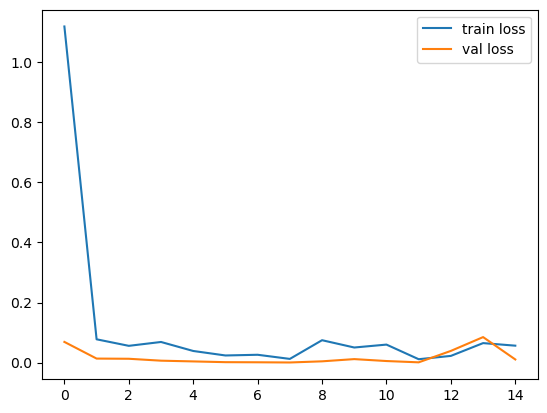

<Figure size 640x480 with 0 Axes>

In [12]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

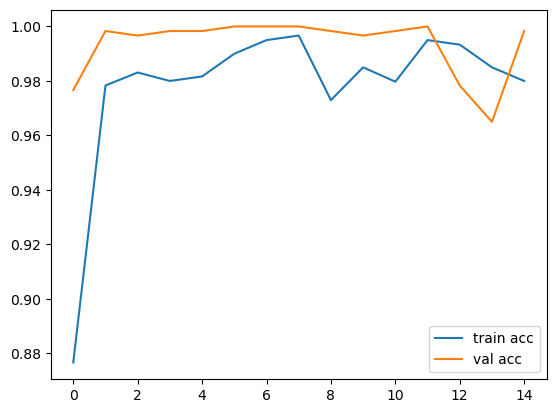

<Figure size 640x480 with 0 Axes>

In [13]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#confusion matrix
y_true = validation_generator.classes

y_pred = model.predict(validation_generator)
predicted_classes = np.argmax(y_pred, axis=1)

from sklearn import metrics
cm = metrics.confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm, display_labels=['Seat_Belt', 'WithoutSeat_Belt']).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

47/77 [=================>............] - ETA: 45s

In [ ]:
#classification report
class_labels = list(validation_generator.class_indices.keys())
report = metrics.classification_report(y_true, predicted_classes, target_names=class_labels, zero_division=1)
print(report)

In [21]:
# Fine-tune the model by unfreezing the top layers of the VGG16 model
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

In [22]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Continue training the model for a few more epochs
history2 = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
323/323 [==============================] - 738s 2s/step - loss: 0.1519 - accuracy: 0.9592 - val_loss: 0.0083 - val_accuracy: 0.9987
Epoch 2/5
323/323 [==============================] - 740s 2s/step - loss: 0.0209 - accuracy: 0.9927 - val_loss: 0.0142 - val_accuracy: 0.9994
Epoch 3/5
323/323 [==============================] - 738s 2s/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 1.9992e-04 - val_accuracy: 1.0000
Epoch 4/5
323/323 [==============================] - 737s 2s/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 8.5553e-05 - val_accuracy: 1.0000
Epoch 5/5
323/323 [==============================] - 738s 2s/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 7.7645e-04 - val_accuracy: 1.0000


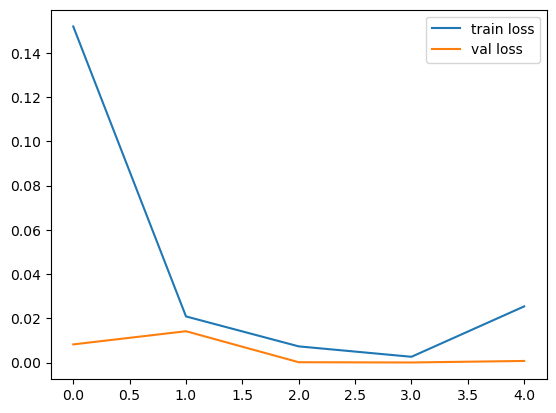

<Figure size 640x480 with 0 Axes>

In [24]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

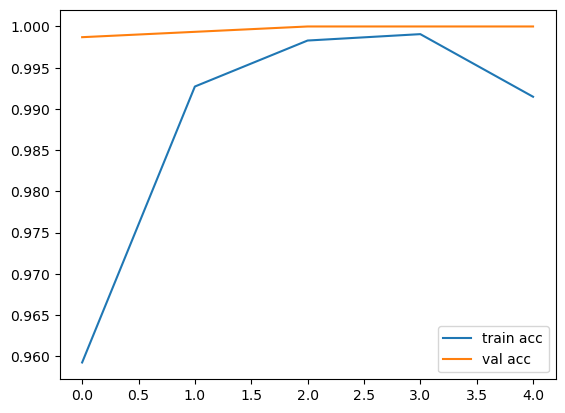

<Figure size 640x480 with 0 Axes>

In [25]:
# accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

77/77 [==============================] - 115s 1s/step


<Figure size 800x600 with 0 Axes>

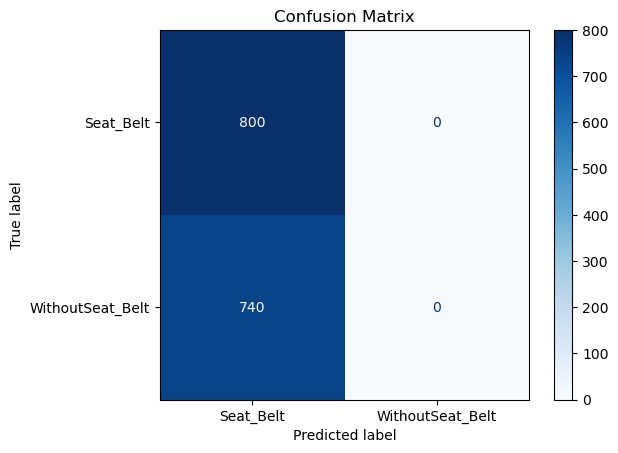

In [26]:
#confusion matrix
y_true = validation_generator.classes

y_pred = model.predict(validation_generator)
predicted_classes = np.argmax(y_pred, axis=1)

from sklearn import metrics
cm = metrics.confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm, display_labels=['Seat_Belt', 'WithoutSeat_Belt']).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [27]:
#classification report
class_labels = list(validation_generator.class_indices.keys())
report = metrics.classification_report(y_true, predicted_classes, target_names=class_labels, zero_division=1)
print(report)

              precision    recall  f1-score   support

  noSeatbelt       0.52      1.00      0.68       800
    seatbelt       1.00      0.00      0.00       740

    accuracy                           0.52      1540
   macro avg       0.76      0.50      0.34      1540
weighted avg       0.75      0.52      0.36      1540



In [28]:
model.save('seatbelt_vs_noseatbelt.h5')

C:\Users\Khalil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
